<a href="https://colab.research.google.com/github/KimRass/Programming/blob/master/Data%20Science/Machine%20Learning/Time%20Series/Quandl%20WIKI%20Stock%20Prices%20%26%20TimeGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modeling" data-toc-modified-id="Modeling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modeling</a></span></li></ul></div>

In [2]:
# Data Science/Machine Learning/Time Series/Quandl WIKI Stock Prices & TimeGAN.ipynb
from google.colab import drive
import os
drive.mount("/content/drive")
os.chdir("/content")

import seaborn as sb
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import time
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer, Dense, Flatten, Dropout, Concatenate, Add, Dot, Multiply, Reshape, Activation, BatchNormalization, LayerNormalization, SimpleRNNCell, RNN, SimpleRNN, LSTM, Embedding, Bidirectional, TimeDistributed, Conv1D, Conv1DTranspose, Conv2D, Conv2DTranspose, MaxPool1D, MaxPool2D, GlobalMaxPool1D, GlobalMaxPool2D, AveragePooling1D, AveragePooling2D, GlobalAveragePooling1D, GlobalAveragePooling2D, ZeroPadding2D, RepeatVector
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adagrad, Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
# MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy, CosineSimilarity
from tensorflow.keras import losses
# MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy, CosineSimilarity
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.activations import linear, sigmoid, relu
from tensorflow.keras.initializers import RandomNormal, glorot_uniform, he_uniform, Constant

plt.style.use("dark_background")

Mounted at /content/drive


In [3]:
os.chdir("/content/drive/MyDrive/TS")
raw_data = pd.read_hdf("Datasets/Quandl WIKI Stock Prices/assets.h5", key="quandl/wiki/prices")

In [4]:
data = raw_data["adj_close"]
data = data.unstack("ticker")
tickers = ["BA", "CAT", "DIS", "GE", "IBM", "KO"]
data = data[tickers]
data = data.dropna()
# data.asfreq("D")

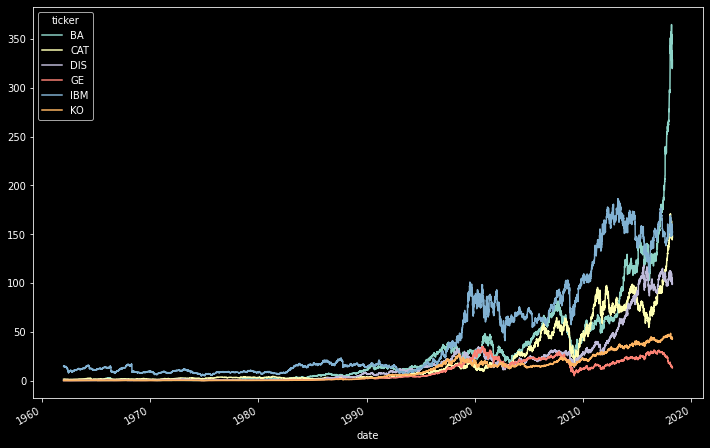

In [5]:
data.plot.line(figsize=(12, 8));

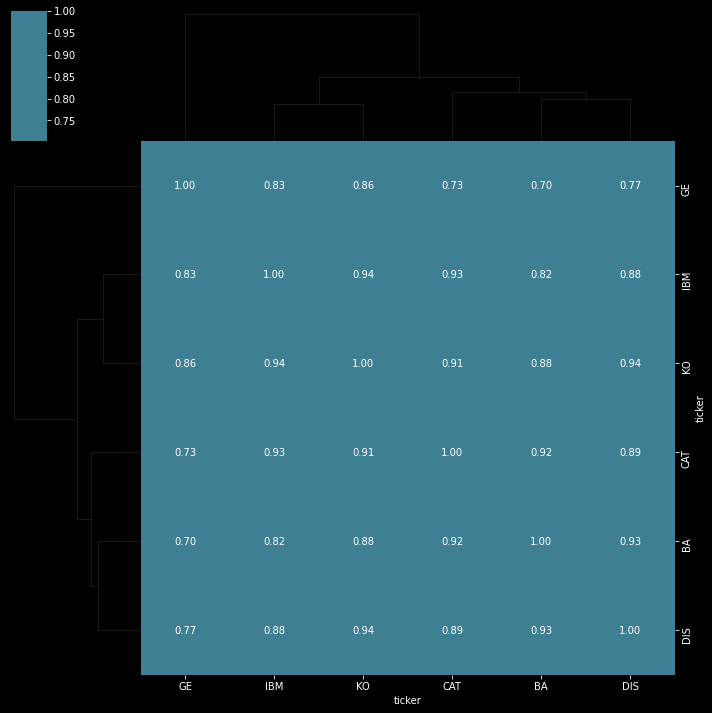

In [6]:
sb.clustermap(data.corr(), annot=True, fmt=".2f", cmap=sb.diverging_palette(h_neg=20, h_pos=220), center=0);

In [7]:
# sc = StandardScaler()
sc = MinMaxScaler()
data_norm = sc.fit_transform(data)

def blocked_cv(data, window_size, h, step=1):
    X = list()
    for i in range(0, len(data) - window_size - h + 1, step):
        X.append(data[i:i + window_size])
    return X

window_size = 24
X = blocked_cv(data_norm, window_size, h=0)

In [8]:
batch_size = 128
dataset_real = tf.data.Dataset.from_tensor_slices(X).shuffle(buffer_size=len(X)).batch(batch_size)
# dataset_real_iter = iter(dataset_real.repeat())

n_features = data_norm.shape[1]
def gen():
    # while True:
    yield np.random.uniform(low=0, high=1, size=(window_size, n_features))
# dataset_rand = iter(tf.data.Dataset.from_generator(gen, output_types=tf.float32).batch(batch_size).repeat())
dataset_rand = tf.data.Dataset.from_generator(gen, output_types=tf.float32).batch(batch_size)

# Modeling

In [9]:
# def make_rnn(hidden_units, output_units, name):
#     return Sequential([GRU(units=hidden_units, return_sequences=True, name=f"GRU_{i + 1}") for i in range(n_layers)] + [Dense(units=output_units, activation="sigmoid", name="OUT")], name=name)
# embedder = make_rnn(hidden_units=hidden_dim, output_units=hidden_dim, name="Embedder")
# recovery = make_rnn(hidden_units=hidden_dim, output_units=n_seq, name="Recovery")
# H = embedder(X)
# X_tilde = recovery(H)

In [10]:
# writer = tf.summary.create_file_writer(log_dir.as_posix())

hidden_dim = 512

# Real data
X = Input(shape=(window_size, n_features), name="Input_real")

z = X
for i in range(3):
    z = LSTM(units=hidden_dim, return_sequences=True)(z)
# Latent representation (Embedding)
H = Dense(units=hidden_dim, activation="sigmoid")(z)
embedder = Model(inputs=X, outputs=H, name="Embedder")

z = H
for i in range(3):
    z = LSTM(units=hidden_dim, return_sequences=True)(z)
# Recovered (Reconstructed) time series
X_tilde = Dense(units=n_features, activation="sigmoid")(z)
# Recovery network from latent representation to the original data.
recovery = Model(inputs=H, outputs=X_tilde, name="Recovery")
# Real data -> Embedder -> Recovery
autoencoder = Model(inputs=X, outputs=X_tilde, name="Autoencoder")

z = H
for i in range(2):
    z = LSTM(units=hidden_dim, return_sequences=True)(z)
# Generated sequence based on the latent representations generated by the `generator`
outputs_supervisor = Dense(units=hidden_dim, activation="sigmoid")(z)
# Generates next sequence using the previous sequence (latent representation).
supervisor = Model(inputs=H, outputs=outputs_supervisor, name="Supervisor")

# Random data
Z = Input(shape=(window_size, n_features), name="Input_rand")

z = Z
for i in range(3):
    z = LSTM(units=hidden_dim, return_sequences=True)(z)
# Generated Latent representation (Embedding)
E_hat = Dense(units=hidden_dim, activation="sigmoid")(z)
# Synthetic data로부터 Latent representation을 만드는 Embedding 방법을 학습합니다. 이렇게 만들어진 Latent representation의 목적인 Real data와 구분되지 않는 그럴듯한 
generator = Model(inputs=Z, outputs=E_hat, name="Generator")

z = E_hat
for i in range(3):
    z = LSTM(units=hidden_dim, return_sequences=True)(z)
# Classification results between the original data and the synthetic data.
Y_hat = Dense(units=1, activation="sigmoid")(z)
discriminator = Model(inputs=E_hat, outputs=Y_hat, name="Discriminator")

H = embedder(X)
X_tilde = recovery(H)
Y_real = discriminator(H)
# Real data -> Embedder -> Discriminator
discriminator_real = Model(inputs=X, outputs=Y_real, name="DiscriminatorReal")

E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)
Y_fake_e = discriminator(E_hat)
X_hat = recovery(H_hat)
# Random data -> Generator -> Supervisor -> Discriminator
adversarial_supervised = Model(inputs=Z, outputs=Y_fake, name="AdversarialNetSupervised")
# Random data -> Generator -> Discriminator
adversarial_emb = Model(inputs=Z, outputs=Y_fake_e, name="AdversarialNet")
# Random data -> Generator -> Supervisor -> Recovery
sythetic_data = Model(inputs=Z, outputs=X_hat, name="SyntheticData")

## Phase 1. Autoencoder Training

In [13]:
epochs = 100
loss_obj_mse = losses.MeanSquaredError()
tr_loss = metrics.Mean()

optimizer_autoencoder = Adam()
@tf.function()
def train_step_autoencoder(X):
    with tf.GradientTape() as tape:
        H = embedder(X)
        X_tilde = recovery(H)
        # e_loss_0
        reconst_loss = 10*tf.math.sqrt(loss_obj_mse(X, X_tilde))
    grads = tape.gradient(reconst_loss, embedder.trainable_variables + recovery.trainable_variables)
    optimizer_autoencoder.apply_gradients(zip(grads, embedder.trainable_variables + recovery.trainable_variables))
    
    tr_loss(reconst_loss)

for epoch in range(1, epochs + 1):
    start = time.time()
    tr_loss.reset_states()
    for batch, X in dataset_real.enumerate(start=1):
        train_step_autoencoder(X)
        if batch%10 == 0:
            print(f"Epoch: {epoch:3d} | Batch: {batch:5d} | Loss: {tr_loss.result():5.4f}")
    if epoch%10 == 0:
        print(f"Epoch: {epoch:3d} | Loss: {tr_loss.result():5.4f}")
        print (f"Time taken for 1 epoch: {time.time() - start:5.0f} secs\n")

Epoch:   1 | Batch:    10 | Loss: 2.8158
Epoch:   1 | Batch:    20 | Loss: 2.6340


KeyboardInterrupt: ignored

## Phase 2. Supervised Training

In [14]:
supervisor_optimizer = Adam()
@tf.function()
def train_step_supervisor(X):
    with tf.GradientTape() as tape:
        H = embedder(X)
        H_hat_supervised = supervisor(H)
        # g_loss_s
        supervised_loss = loss_obj_mse(H[:, 1:, :], H_hat_supervised[:, :-1, :])

    grads = tape.gradient(supervised_loss, supervisor.trainable_variables)
    supervisor_optimizer.apply_gradients(zip(grads, supervisor.trainable_variables))
    
    tr_loss(supervised_loss)

for epoch in range(1, epochs + 1):
    start = time.time()
    tr_loss.reset_states()
    for batch, x in dataset_real.enumerate(start=1):
        train_step_supervisor(x)
        if batch%10 == 0:
            print(f"Epoch: {epoch:3d} | Batch: {batch:5d} | Loss: {tr_loss.result():5.4f}")
    if epoch%10 == 0:
        print(f"Epoch: {epoch:3d} | Loss: {tr_loss.result():5.4f}")
        print (f"Time taken for 1 epoch: {time.time() - start:5.0f} secs\n")

Epoch:   1 | Batch:    10 | Loss: 0.0070
Epoch:   1 | Batch:    20 | Loss: 0.0043
Epoch:   1 | Batch:    30 | Loss: 0.0031


KeyboardInterrupt: ignored

## Phase 3. Joint Training

In [ ]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z, outputs=Y_fake_e, name="AdversarialNet")

In [ ]:
adversarial_emb.summary()

In [ ]:
plot_model(adversarial_emb, show_shapes=True)

In [ ]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name="SyntheticData")

In [ ]:
synthetic_data.summary()

In [ ]:
plot_model(synthetic_data, show_shapes=True)

In [ ]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

In [ ]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name="DiscriminatorReal")

In [ ]:
discriminator_model.summary()

In [ ]:
plot_model(discriminator_model, show_shapes=True)

In [ ]:
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

In [ ]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

In [ ]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

In [ ]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(dataset_real_iter)
        Z_ = next(dataset_rand)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(dataset_real_iter)
    Z_ = next(dataset_rand)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(f"{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | "
              f"g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}")

    with writer.as_default():
        tf.summary.scalar("G Loss S", step_g_loss_s, step=step)
        tf.summary.scalar("G Loss U", step_g_loss_u, step=step)
        tf.summary.scalar("G Loss V", step_g_loss_v, step=step)
        tf.summary.scalar("E Loss T0", step_e_loss_t0, step=step)
        tf.summary.scalar("D Loss", step_d_loss, step=step)

In [ ]:
synthetic_data.save(log_dir / "synthetic_data")

In [ ]:
generated_data = []
for i in range(int(n_windows/batch_size)):
    Z_ = next(dataset_rand)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [ ]:
len(generated_data)

In [ ]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

In [ ]:
np.save(log_dir/"generated_data.npy", generated_data)

In [ ]:
generated_data = (scaler.inverse_transform(generated_data.reshape(-1, n_seq)).reshape(-1, window_size, n_seq))
generated_data.shape

In [ ]:
with pd.HdataStore(hdata_store) as store:
    store.put("data/synthetic", pd.DataFrame(generated_data.reshape(-1, n_seq), columns=tickers))

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))
axes = axes.flatten()

index = list(range(1, 25))
synthetic = generated_data[np.random.randint(n_windows)]

idx = np.random.randint(len(data) - window_size)
real = data.iloc[idx: idx + window_size]

for j, ticker in enumerate(tickers):
    (pd.DataFrame({"Real": real.iloc[:, j].values,
                   "Synthetic": synthetic[:, j]})
     .plot(ax=axes[j],
           title=ticker,
           secondary_y="Synthetic", style=["-", "--"],
           lw=1))
sb.despine()
fig.tight_layout()